# <span style='color:blue'> Activity Class Prediction for unseen compounds: model scope validation</span>

The present `Jupyter Notebook` contains the evaluation of Applicability Domain for the selected ML classifiers and assessment of their scope using published data sets. 

## Import Essentials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import pickle

In [2]:
# Import functions from customized modules
from pathlib import Path
import sys

PROJECT_DIR = list(Path("..").absolute().parents)[0]
sys.path.append(str(PROJECT_DIR) + '/Scripts/')

from preprocessing import feature_filt_adv
from classification import scoring_new_class
from tools import activity_conversion, act_conv_calib, prepare_new_data, compile_summary

## File names and colors

In [3]:
# File names and sheet names
descriptors_file = './Data/BTZs_full_descriptors_final.xlsx'
data_matrix = 'general_data_matrix'
desc = 'descriptors'

new_compounds = './Data/published_BTZs_data.csv'

activity_calib = './Data/Comparison_Mvaccae_vs_TB.xlsx'

stats_external = './Results/Statistical_results_reported_BTZs.csv'
conf_mat_external = './Results/Confusion_matrix_reported_BTZs.csv'
final_report_M5 = './Results/Predictions_for_reported_BTZs_by_M5.xlsx'

In [4]:
colors1 = ['#ca0020', '#f4a582', '#92c5de', '#0571b0']

## Load and prepare data  

This data frame was obtained during data preparation in Notebook 1. 

In [5]:
# Load data set with SMILES
BTZs = pd.read_excel(descriptors_file, sheet_name=data_matrix)

# Load set of descriptors 
desc = pd.read_excel(descriptors_file, sheet_name=desc)

In [6]:
# Create X data sets from descriptors and molecular fingerprints
Xdesc = desc.iloc[:, 1:] 
print('X descriptors shape {}'.format(Xdesc.shape))

X descriptors shape (96, 227)


In [7]:
y = BTZs.Class

print('y shape {}'.format(y.shape))

y shape (96,)


## Load new, unseen compounds 

In [8]:
# load data saved in Notebook 4
new_data = pd.read_csv(new_compounds, index_col=0)

In [9]:
# Define columns that are not in common, so they can be eliminated
exc = [x for x in new_data.columns if x not in set(Xdesc.columns)]

In [10]:
# Create X and y
Xnew = new_data.copy()
# Drop those columns from new_data
Xnew.drop(columns=exc, inplace=True)

# Reorganize column MW to the end
cols = Xnew.columns.to_list()
cols = cols[1:] + cols[:1]
Xnew = Xnew[cols]
Xnew.dropna(inplace=True)
print(Xnew.shape)

(266, 227)


In [11]:
# verify
c = 0
for i, j in zip(Xnew.columns, Xdesc.columns):
    if i == j:
        c += 1
print(c)

227


## Load data for activity conversion

In [12]:
# Load data for correction of activity by regression 
data_correction_act = pd.read_excel(activity_calib, sheet_name='pMIC_values')

## Load Models

The four selected algorithms are used in subsequent calculations: Random Forest, Support Vector Machines, K-Nearest Neighbohrs, and AdaBoost. The models were instantiated and saved before. 

In [13]:
# Create a dictionary with the four models previously saved
models = {}
for label in ['M2', 'M5', 'M37', 'M38']:
    with open('./Results/' + label + '.pkl', 'rb') as file:
        models[label] = pickle.load(file)

### Filter keeping only relevant *Mycobacteria* strains

In [14]:
# Only interested in M. vaccae and Mtb H37Rv. The other will be excluded
exc_row = [x for x in new_data.index if new_data.M_species[x][-5:] not in ['accae', 'H37Rv']]

In [15]:
new_data.drop(exc_row, inplace=True)
new_data.shape

(203, 285)

In [16]:
# Define columns that are not in common, so they can be eliminated
exc_col = [x for x in new_data.columns if x not in set(Xdesc.columns)]

In [17]:
# Create X and y
Xnew = new_data.copy()
# Drop those columns from new_data
Xnew.drop(columns=exc_col, inplace=True)

# Reorganize column MW to the end
cols = Xnew.columns.to_list()
cols = cols[1:] + cols[:1]
Xnew = Xnew[cols]
Xnew.dropna(inplace=True)
print(Xnew.shape)

(203, 227)


In [18]:
# verify
c = 0
for i, j in zip(Xnew.columns, Xdesc.columns):
    if i == j:
        c += 1
print(c)

227


## Conversion of activity values from *Mtb* to *M. vaccae*

In [19]:
# Use customized function to calculated activity values (and classes)
_ , calib_corr, stats_MIC_cor, vp = act_conv_calib(data_correction_act)

In [20]:
# Statistics for the OLS used for activity conversion
stats_MIC_cor

,R2,RMSE,MAE
0,0.836601,0.539661,0.39025


In [21]:
# Slope and intercept from calibration
vp

[1.1069935121192205, -0.1096916557707317]

<Figure size 432x288 with 0 Axes>

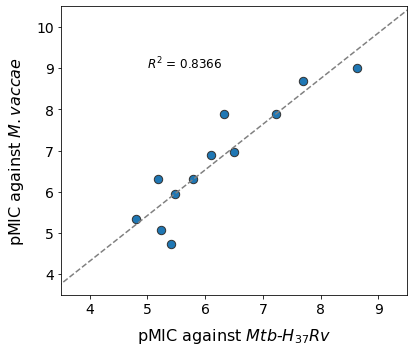

In [22]:
# Generate a plot 
plt.figure()
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_box_aspect(1/1.2)
ax.scatter(data_correction_act['Mtb-H37Rv'], data_correction_act['Mvaccae'], s=70, edgecolors=[0.2, 0.2, 0.2])
ax.set_xlabel('pMIC against $\it{Mtb}$-$H_{37}Rv$', fontsize=16, labelpad=10)
ax.set_ylabel('pMIC against $\it{M. vaccae}$', fontsize=16, labelpad=10)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit(data_correction_act['Mtb-H37Rv'], data_correction_act['Mvaccae'], 1)
p = np.poly1d(z)
xx = np.arange(3, 12, 0.5)
ax.plot(xx, p(xx), "--", c='gray')

ax.set_xlim((3.5, 9.5))
ax.set_ylim((3.5, 10.5))

ax.text(5, 9, '$R^2$ = {}'.format(np.round(stats_MIC_cor.R2.values[0], 4)), fontsize=12)

fig.tight_layout()

plt.show()

In [23]:
# Correct activity 
MIC_cor, newClass = activity_conversion(data_correction_act, new_data)

In [24]:
len(newClass)

203

## AD and predictions with M2

In [26]:
# Define parameters for AD methods
ad_params = {
    'neighbors': 5, 
    'percentile': 95, 
    'lev_thr': 3, 
    }

In [25]:
# Prepare new data as for training 
X_train57, y_train57, Xnew_scaled57 = prepare_new_data(Xnew, Xdesc, y, 0.25, 57)

In [27]:
# Create a summary dataframe
summary_M2 = compile_summary(models['M2'], X_train57, y_train57, Xnew_scaled57, ad_params, newClass, MIC_cor)

In [28]:
# Evaluate results
results_new_M2 = pd.DataFrame(columns=['data', 'AUC', 'Brier', 'BA', 'f1', 'MCC'])
tmp = summary_M2[(summary_M2[:, 3] == 1) & (summary_M2[:, 4] == 1)]
for lab, inf in zip(['whole', 'far_boundary'], [summary_M2, tmp]):
    stats = scoring_new_class(inf[:, 0], inf[:, 1], inf[:, 2])
    results_new_M2.loc[len(results_new_M2)] = [lab] + stats

## AD and predictions with M5

In [31]:
# Prepare data according to the model training
X_train31, y_train31, Xnew_scaled31 = prepare_new_data(Xnew, Xdesc, y, 0.25, 31)

In [32]:
# Create summary dataframe
summary_M5 = compile_summary(models['M5'], X_train31, y_train31, Xnew_scaled31, ad_params, newClass, MIC_cor)

In [33]:
# Evaluate results
results_new_M5 = pd.DataFrame(columns=['data', 'AUC', 'Brier', 'BA', 'f1', 'MCC'])
tmp = summary_M5[(summary_M5[:, 3] == 1) & (summary_M5[:, 4] == 1)]
for lab, inf in zip(['whole', 'far_boundary'], [summary_M5, tmp]):
    stats = scoring_new_class(inf[:, 0], inf[:, 1], inf[:, 2])
    results_new_M5.loc[len(results_new_M5)] = [lab] + stats

## Predictions with M37

In [34]:
# Create summary dataframe
summary_M37 = compile_summary(models['M37'], X_train57, y_train57, Xnew_scaled57, ad_params, newClass, MIC_cor)

In [35]:
# Evaluate results
results_new_M37 = pd.DataFrame(columns=['data', 'AUC', 'Brier', 'BA', 'f1', 'MCC'])
tmp = summary_M37[(summary_M37[:, 3] == 1) & (summary_M37[:, 4] == 1)]
for lab, inf in zip(['whole', 'far_boundary'], [summary_M37, tmp]):
    stats = scoring_new_class(inf[:, 0], inf[:, 1], inf[:, 2])
    results_new_M37.loc[len(results_new_M37)] = [lab] + stats

## Predictions with M38

In [37]:
# Create summary dataframe
summary_M38 = compile_summary(models['M38'], X_train31, y_train31, Xnew_scaled31, ad_params, newClass, MIC_cor)

In [38]:
# Evaluate results
results_new_M38 = pd.DataFrame(columns=['data', 'AUC', 'Brier', 'BA', 'f1', 'MCC'])
tmp = summary_M38[(summary_M38[:, 3] == 1) & (summary_M38[:, 4] == 1)]
for lab, inf in zip(['whole', 'far_boundary'], [summary_M38, tmp]):
    stats = scoring_new_class(inf[:, 0], inf[:, 1], inf[:, 2])
    results_new_M38.loc[len(results_new_M38)] = [lab] + stats

## Comparing statistics for all selected models

In [39]:
# Add column with label to each dataframe
for lab, df in zip(['M2', 'M5', 'M37', 'M38'],
                   [results_new_M2, results_new_M5, results_new_M37, results_new_M38]):
    df['classifier'] = [lab] * 2

In [40]:
# Bring together all the results
global_results = pd.concat((results_new_M2, 
                            results_new_M5, 
                            results_new_M37, 
                            results_new_M38), axis=0)

In [41]:
global_results

,data,AUC,Brier,BA,f1,MCC,classifier
0,whole,0.587080,0.318809,0.541941,0.476190,0.086031,M2
1,far_boundary,0.612575,0.293372,0.540807,0.461538,0.085803,M2
0,whole,0.698446,0.223214,0.697881,0.775330,0.383985,M5
1,far_boundary,0.746544,0.201123,0.724819,0.803922,0.463257,M5
0,whole,0.683845,0.245371,0.623629,0.612500,0.242348,M37
1,far_boundary,0.724955,0.221727,0.658542,0.652632,0.317084,M37
0,whole,0.696893,0.241848,0.663136,0.676617,0.309168,M38
1,far_boundary,0.745929,0.213669,0.711160,0.711864,0.414519,M38


In [42]:
# Export the results
global_results.to_csv(stats_external)

In [43]:
# Defina an empty dataframe to store confusion matrixes
global_confusion_matrix = pd.DataFrame(columns=['data', 'tn', 'fp', 'fn', 'tp', 'classifier'])

# Calculate confusion matrix for each model using both the whole data set and 
# the reduced data set (after removal of samples close to boundaries)
for lab, df in zip(['M2', 'M5', 'M37', 'M38'],
                   [summary_M2, summary_M5, summary_M37, summary_M38]):
    tn, fp, fn, tp = confusion_matrix(df[:, 0], df[:, 1]).ravel()
    global_confusion_matrix.loc[len(global_confusion_matrix)] = ['whole'] + [tn, fp, fn, tp] + [lab]
    
    tmp = df[(df[:, 3] == 1) & (df[:, 4] == 1)]
    tn, fp, fn, tp = confusion_matrix(tmp[:, 0], tmp[:, 1]).ravel()
    global_confusion_matrix.loc[len(global_confusion_matrix)] = ['far_boundary'] + [tn, fp, fn, tp] + [lab]

In [44]:
global_confusion_matrix

,data,tn,fp,fn,tp,classifier
0,whole,41,16,61,35,M2
1,far_boundary,34,13,43,24,M2
2,whole,39,21,30,88,M5
3,far_boundary,19,12,8,41,M5
4,whole,42,15,47,49,M37
5,far_boundary,31,12,21,31,M37
6,whole,45,15,50,68,M38
7,far_boundary,35,9,25,42,M38


In [45]:
# Export the results
global_confusion_matrix.to_csv(conf_mat_external)

<Figure size 432x288 with 0 Axes>

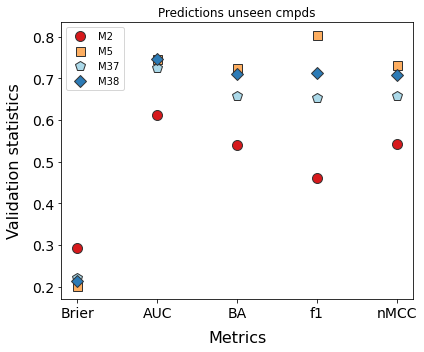

In [47]:
# Create a plot of statistical results

labels = ['Brier', 'AUC', 'BA', 'f1', 'nMCC']

# Reorganize the dataframe
stats_plot2 = stats_plot.iloc[:, 1:5]
stats_plot2['nMCC'] = (stats_plot.MCC + 1) / 2
stats_plot2['Model'] = stats_plot.classifier
stats_plot2 = stats_plot2[['Model'] + labels]

x1 = np.arange(len(labels))  # the label locations

plt.figure()
fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.plot(x1, stats_plot2.iloc[0,1:], linestyle='', color='#d7191c', marker='o', 
                 markersize=10, markeredgecolor=[0.2, 0.2, 0.2], label=stats_plot2.Model.iloc[0])
rects2 = ax.plot(x1, stats_plot2.iloc[1,1:], linestyle='', color='#fdae61', marker='s', 
                 markersize=9, markeredgecolor=[0.2, 0.2, 0.2], label=stats_plot2.Model.iloc[1])
rects3 = ax.plot(x1, stats_plot2.iloc[2,1:], linestyle='', color='#abd9e9', marker='p', 
                 markersize=11, markeredgecolor=[0.2, 0.2, 0.2], label=stats_plot2.Model.iloc[2])
rects4 = ax.plot(x1, stats_plot2.iloc[3,1:], linestyle='', color='#2c7bb6', marker='D', 
                 markersize=8, markeredgecolor=[0.2, 0.2, 0.2], label=stats_plot2.Model.iloc[3])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation statistics', fontsize=16, labelpad=10)
ax.set_xlabel('Metrics', fontsize=16, labelpad=10)
ax.set_title('Predictions unseen cmpds')
ax.set_xticks(x1)
ax.set_xticklabels(labels)
ax.tick_params(axis='both', labelsize=14)
ax.legend()

fig.tight_layout()

plt.show()

## Final report

Compile information to report in manuscript

In [48]:
# Create names
names = new_data.index.values
# Run again applicability domain but generate report
summary_M5, report_M5 = compile_summary(models['M5'], X_train31, y_train31, Xnew_scaled31, 
                                             ad_params, newClass, MIC_cor, 
                                             gen_rep=True, names=names)

In [49]:
rep_act = new_data.loc[names, 'MIC_M'] * 1e6
rep_act.reset_index(drop=True, inplace=True)
n = new_data.loc[names,['Smiles', 'M_species']].copy()
n.reset_index(drop=True, inplace=True)
report_M5_to_export = pd.concat((n, 
                                 rep_act,
                                 pd.Series(MIC_cor),
                                 report_M5), axis=1)
report_M5_to_export.columns = ['Smiles', 'M_species', 'Reported MIC (uM)', 'Transformed MIC (uM)',
                               'ID', 'AD', 'Pred class', 'Pred Probability']

In [50]:
report_M5_to_export

,Smiles,M_species,Reported MIC (uM),Transformed MIC (uM),ID,AD,Pred class,Pred Probability
0,O=C1N=C(N2CCN(C/C(C)=N/OC)CC2)SC3=C([N+]([O-])...,MTB H37Rv,0.083127,0.018702,175.0,1.0,1.0,58.67
1,O=C1N=C(N2CCN(C/C(C)=N/OCC)CC2)SC3=C([N+]([O-]...,MTB H37Rv,0.034849,0.007144,176.0,1.0,1.0,55.06
2,O=C1N=C(N2CCN(C/C(C)=N/OCC3=CC=CC=C3)CC2)SC4=C...,MTB H37Rv,0.030702,0.006209,177.0,1.0,1.0,77.71
3,O=C1N=C(N2CCN(CC/C(C)=N/OC)CC2)SC3=C([N+]([O-]...,MTB H37Rv,0.034849,0.007144,178.0,1.0,1.0,53.01
4,O=C1N=C(N2CCN(CC/C(C)=N/OCC)CC2)SC3=C([N+]([O-...,MTB H37Rv,0.033817,0.006910,179.0,1.0,1.0,54.58
...,...,...,...,...,...,...,...,...
198,O=C(C(N12)=C(COC(OC(Cl)C(Cl)(Cl)Cl)=O)CS[C@]2(...,MTB H37Rv,50.000000,22.308962,429.0,0.0,NaN,NaN
199,O=C(C(N12)=C(COC(N3CCN(C(SC4=C([N+]([O-])=O)C=...,MTB H37Rv,4.630000,1.601491,430.0,0.0,NaN,NaN
200,O=C(C(N12)=C(CN3CCN(C(SC4=C([N+]([O-])=O)C=C(C...,MTB H37Rv,2.030000,0.642875,431.0,0.0,NaN,NaN
201,O=C(C(N12)=C(CN3CCN(C(SC4=C([N+]([O-])=O)C=C(C...,MTB H37Rv,100.000000,48.052679,432.0,0.0,NaN,NaN


In [51]:
report_M5_to_export.to_excel(final_report_M5)